In [1]:
import prescient.utils
import numpy as np
import pandas as pd
import sklearn
import umap
import scipy
import annoy
import torch
import matplotlib.pyplot as plt

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


## Load data

Make sure to have downloaded the Veres 2019 et. al. data to this directory as described on the "Usage notebooks" tab.

In [2]:
expr = pd.read_csv("Veres2019/Stage_5.Seurat.csv", index_col=0)
expr.head()

,SST,PYY,GCG,TTR,PPY,TAC1,GC,INS,NTS,CCK,...,LANCL3,FAM193A,FMN1,TPM1,VWA8,ERMAP,PTGS1,HEYL,C9orf43,ANKRD20A4
stg5diff1_S5d0_b1.bcEKBI,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.716086,0.0,...,0.0,0.420816,0.0,1.829704,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcDAND,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.866169,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcGQEK,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.007309,0.0,2.073536,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcFOEC,0.000000,0.0,0.0,1.175463,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.700974,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcAVAX,1.272205,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.272205,0.0,0.000000,1.272205,0.0,0.0,0.0,0.0,0.0


In [3]:
metadata = pd.read_csv("Veres2019/GSE114412_Stage_5.all.cell_metadata.csv", index_col = 0)
metadata.head()

,Assigned_cluster,Assigned_subcluster,tSNE_dim1,tSNE_dim2,Differentiation,CellWeek,Lib_prep_batch,Indrops_barcode_sequence
library.barcode,,,,,,,,
stg5diff1_S5d0_b1.bcEKBI,prog_sox2,prog_sox2,-23.483145,-17.515814,1,0,stg5diff1_S5d0_b1,AGGCAACG-AAGCGTAC
stg5diff1_S5d0_b1.bcDAND,fev_high_isl_low,fev_high_isl_low__day0,6.776112,29.839868,1,0,stg5diff1_S5d0_b1,GAATGGAAAT-AGCGAAGT
stg5diff1_S5d0_b1.bcGQEK,prog_sox2,prog_sox2,-27.248994,-14.215368,1,0,stg5diff1_S5d0_b1,TGAGGTCTGAC-TCTCACTT
stg5diff1_S5d0_b1.bcFOEC,prog_sox2,prog_sox2,-30.845154,-7.473947,1,0,stg5diff1_S5d0_b1,ACTGAGTGC-AAGCGTAC
stg5diff1_S5d0_b1.bcAVAX,prog_sox2,prog_sox2,-7.391701,-16.014836,1,0,stg5diff1_S5d0_b1,AGATGTATT-ATGACTTT


## Scale normalized expression for PCA
For PCA dimensionality reduction, scaled features are necessary. Here we use sklearn's StandardScaler().

In [4]:
scaler = sklearn.preprocessing.StandardScaler()
xs = pd.DataFrame(scaler.fit_transform(expr), index = expr.index, columns = expr.columns)

In [5]:
pca = sklearn.decomposition.PCA(n_components = 30)
xp_ = pca.fit_transform(xs)

## Computing growth using built-in PRESCIENT commands

In [6]:
g, g_l=prescient.utils.get_growth_weights(xs, xp_, metadata, tp_col="CellWeek", genes=list(expr.columns), 
                   birth_gst="Veres2019/hs_birth_msigdb_kegg.csv",
                   death_gst="Veres2019/hs_death_msigdb_kegg.csv",
                   outfile="Veres2019/tutorial-example-growth-kegg.pt"
                  )

## Visualize growth weights
You can now visualize the computed growth/proliferation score per cell on a UMAP visualization of the data.

In [7]:
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30)
xu = um.fit_transform(xp_)

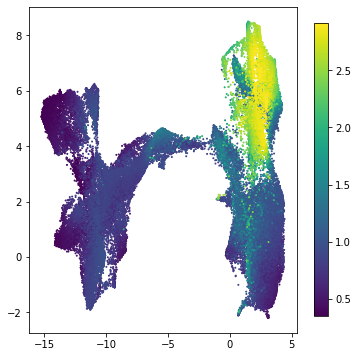

In [8]:
fig, ax = plt.subplots(figsize = (6,6))

c = np.exp(g)
ci = np.argsort(c)
sax = ax.scatter(-xu[ci,0], xu[ci,1], s = 1, c = c[ci])

plt.colorbar(sax, shrink = 0.9)

## Use weight torch file in process_data command

You can now use the growth weights file produced in the process_data command as follows:
```
prescient process_data -d data/Veres2019/Stage_5.Seurat.csv -m data/Veres2019/GSE114412_Stage_5.all.cell_metadata.csv --growth_path data/Veres2019/growth-kegg.pt -o './' --tp_col 'CellWeek' --celltype_col 'Assigned_cluster'
```
This command will produce a ```data.pt``` file that is used for the remainder of the training, simulation, and perturbation steps of PRESCIENT as outlined in Quickstart and Documentation.